## IMPORT MODULES

In [ ]:
import numpy as np # 선형대수 모듈
import matplotlib.pyplot as plt # 시각화 모듈
import torch # 파이토치
import torch.nn as nn # PyTorch의 모듈을 모아놓은 것. from~~이 아닌 저렇게 임포트를 하는 것이 거의 관습이라고 한다.
import torch.nn.functional as F # torch.nn 중에서 자주 쓰는 함수를 F로 임포트.
import torch.nn.init as init # 초기화 관련 모듈
import torchvision # TorchVision 임포트
from torchvision import transforms, datasets # 데이터를 다루기 위한 TorchVision 내의 Transforms와 datasets를 따로 임포트

## DEVICE 설정
Google Colab으로 프로그램을 구성하는데 미리 노트북 설정에서 GPU를 해야 cuda.is_available()이 True가 나와 cuda:0으로 설정이 된다.
ATCH_SIZE는 한 번에 학습을 실행할 때 사용할 데이터의 크기를 정한다.
여기에서는 32로 하였다. 메모리가 허용해 주는 한 어느 정도 크게 하는 게 좋다.
EPOCHS는 전체 데이터를 다 한 번 학습을 돌리는 게 1EPOCH이니 여기에선 전체 데이터를 30번 학습한다는 말이 된다. Epoch과 Batch Size의 관계는 Epoch = iterations ∗ Batch Size이다.

In [ ]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

BATCH_SIZE = 32
EPOCHS = 30

print('Using PyTorch version: ', torch.__version__, 'Device: ', DEVICE)

Using PyTorch version:  2.1.0+cu121 Device:  cuda:0


---

## MNIST 데이터 설정

In [ ]:
train_dataset = datasets.MNIST(
    root="../data/MNIST",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root="../data/MNIST",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 160726285.77it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44848461.25it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43083492.06it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3244852.46it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



**해설**

datasets.MNIST로 MNIST의 데이터 셋을 불러올 수가 있다. train 옵션을 True로 넣어주는 것만으로 Train Data set으로 설정할 수 있으며 Test는 당연히 train=False로 하면 된다.
transform 옵션은 전처리에 관련된 내용인데, 각각의 필기 그림을 텐서 형태로만 변환해 준다. 각 픽셀을 0~1 사이의 값으로 정규화를 해 준다.
DataLoader는 단순하게 위에서 불러온 dataset을 사전에 설정한 batch size(32)로 미니 배치 설정을 할 수 있도록 해 준다.

---

## 데이터 체크

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


**해설**

train_loader에서 각 미니배치 별로 데이터가 출력되기 때문에 break문을 써주지 않는다면 같은 모양의 출력이 여러 번(엄청 많이) 나온다. 어차피 다 같기 때문에 break를 걸어서 한 번씩만 출력시킨다.
28, 28은 하나의 손글씨 그림의 크기(가로세로 28 pixel)이며 32개 당 하나의 Mini Batch이므로 32,1,28,28의 사이즈가 나온다.
y_train은 이미지 하나에 대한 정답 텐서이기 때문에 32라는 롱텐서 하나만 출력된다.

## 이미지 출력

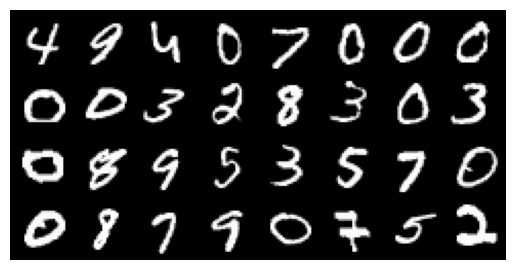

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # iterator
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))

**해설**

이 코드는 매번 실행할 때마다 다른 32개의 숫자 그림이 나온다.
누가 썼는지 글씨 정말 이상하게 쓴다.

---

## MLP(Multi Layer Perceptron) 모델 설계

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5 # 50%의 노드에 대한 가중치 계산을 하지 않기 위한 설정
        self.batch_norm1 = nn.BatchNorm1d(512) # 1dimension이기 때문에 BatchNorm1d를 사용함.
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x) # sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x) # sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x



```
self.dropout_prob = 0.5 # 50%의 노드에 대한 가중치 계산을 하지 않기 위한 설정

x = F.dropout(x, training=self.training, p=self.dropout_prob)
```

신경망 학습 과정에서 랜덤하게 Drop을 시켜서 가중치 계산을 하지 않는 방법을 통해 Generalization 효과를 주기 위한 장치인데, 모델 init에서 변수 선언을 해 놓는 것이다.
인간의 유전 알고리즘 중에서 돌연변이의 개념을 차용한 것이라고 한다.
relu 뒤에서 p값으로 위의 dropout_prob을 넣어서 dropout 함수를 사용한다.



```
self.batch_norm1 = nn.BatchNorm1d(512) # 1dimension이기 때문에 BatchNorm1d를 사용함.

x = self.batch_norm1(x)
```

각 Layer마다 입력값 분포가 달라짐에 따른 학습 속도 저하를 방지하기 위한 Batch Normalization 기법을 사용하도록 한다. 이를 통해 Input 분포를 정규화 함으로써 학습 속도를 높인다.
fully connected의 함수 뒤에서 사용하며 이 때 각각 512, 256인 것을 그대로 집어 넣는다.

---

### 초기화, Optimizer, 함수 설정

In [ ]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = MLP().to(DEVICE) # 정의한 모델을 GPU로 납치
model.apply(weight_init)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# print(model)

**해설**

앞서 맨 처음의 모듈 임포트 때 언급한 init을 여기에서 사용한다.
여기에서의 init은 신경망의 초기화를 의미한다.
초기화를 어떻게 하느냐에 따라 초기 Loss 값이 달라진다고 한다.
최적의 신경망 Loss를 갖기 위해서 어디에서 초기 Loss가 스타트 하느냐가 중요한데 그것을 여기에서 잡아주는 것이다.
여기에서는 He Initialization이라는 초기화 기법을 사용하도록 한다.



```
if isinstance(m, nn.Linear):
	init.kaiming_uniform_(m.weight.data)
    
model.apply(weight_init)
```

파라미터 중에서 mm.Linear 오브젝트에 해당하는 것에 대해서만 초기화를 진행하도록 한다. 여기서의 kaiminguniform이라는 것이 he initialization을 의미한다.
그리고 이 초기화 함수를 model.apply를 통해 적용시킨다.


`optimizer = torch.optim.Adam(model.parameters(), lr=0.01)`

딥러닝에서 가장 많이 사용하는 Optimizer인 Adam을 사용한다. 러닝 레이트는 0.01로 지정한다.

---

## 학습 함수 정의

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

**해설**

위에서 모델 정의 후 GPU로 납치했듯 이미지와 라벨 역시 GPU로 납치해야 한다.
zero_grad의 경우, 이전에 계산되었던 gradient를 이용하지 않게 하기 위해 사용한다.
또한 한 번의 feed-forward를 model(image)를 통해 거친 뒤, Cross Entropy를 통해 로스 계산 후, back propagation을 하는 것이 한 번의 iteration이다.
optimizer.step()에서는 파라미터값을 업데이트 한다.

---

## 검증 함수 정의

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

**해설**



```
with torch.no_grad():
```

검증 단계에서의 코드에서는 파라미터가 업데이트 되면 안 된다. 그래서 no_grad로 방지한다.


```
output = model(image)
```

모델로 test_loader에서 뽑은 image를 사용해 output 계산.


```
test_loss += loss_fn(output, label).item()
```
Cross Entropy를 사용해 loss를 계산해 test_loss에 더함.

```
prediction = output.max(1, keepdim=True)[1]
```

Ouput이 크기 10의 벡터이기 때문에 가장 큰 숫자를 예측값 prediction으로 정의한다.

```
prediction = output.max(1, keepdim=True)[1]
```

예측이 정답과 일치하는지를 확인하여 일치하면 correct 변수에 더한다.

---

## 학습 진행 및 확인

In [ ]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=100)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(
        Epoch, test_loss, test_accuracy
    ))

[EPOCH: 1], 	Test Loss: 0.0047, 	Test Accuracy: 95.07 %
[EPOCH: 2], 	Test Loss: 0.0034, 	Test Accuracy: 96.78 %
[EPOCH: 3], 	Test Loss: 0.0028, 	Test Accuracy: 97.34 %
[EPOCH: 4], 	Test Loss: 0.0027, 	Test Accuracy: 97.32 %
[EPOCH: 5], 	Test Loss: 0.0023, 	Test Accuracy: 97.74 %
[EPOCH: 6], 	Test Loss: 0.0023, 	Test Accuracy: 97.53 %
[EPOCH: 7], 	Test Loss: 0.0024, 	Test Accuracy: 97.69 %
[EPOCH: 8], 	Test Loss: 0.0022, 	Test Accuracy: 97.80 %
[EPOCH: 9], 	Test Loss: 0.0022, 	Test Accuracy: 97.90 %
[EPOCH: 10], 	Test Loss: 0.0021, 	Test Accuracy: 98.12 %
[EPOCH: 11], 	Test Loss: 0.0021, 	Test Accuracy: 97.93 %
[EPOCH: 12], 	Test Loss: 0.0021, 	Test Accuracy: 98.04 %
[EPOCH: 13], 	Test Loss: 0.0021, 	Test Accuracy: 98.05 %
[EPOCH: 14], 	Test Loss: 0.0020, 	Test Accuracy: 98.14 %
[EPOCH: 15], 	Test Loss: 0.0018, 	Test Accuracy: 98.35 %
[EPOCH: 16], 	Test Loss: 0.0019, 	Test Accuracy: 98.15 %
[EPOCH: 17], 	Test Loss: 0.0020, 	Test Accuracy: 98.09 %
[EPOCH: 18], 	Test Loss: 0.0021, 	Test A

처음에 설정한 1부터 31까지, 즉 30 Epoch 만큼 학습 및 검증을 실행한다.